In [17]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd

model_path = "/kaggle/input/saved3/tensorflow2/default/1/Model.keras" 
image_dir = "/kaggle/input/sample1111/sample1"
TRAIN_CSV = "/kaggle/input/trained/train_2020_and_2019_with_9_Labels.csv"

model = tf.keras.models.load_model(model_path, compile=False)


In [18]:
def make_gradcam_heatmap(img_array, model, pred_index=None):


    backbone = model.get_layer("efficientnetb5")


    last_conv_layer = backbone.get_layer("top_activation")


    x = backbone.output
    x = model.get_layer("top_flatten")(x)
    x = model.get_layer("dense_500")(x)
    x = model.get_layer("dense_256")(x)
    output = model.get_layer("output_layer")(x)


    grad_model = tf.keras.models.Model(
        inputs=backbone.input,
        outputs=[last_conv_layer.output, output]
    )


    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array, training=False)

        if pred_index is None:
            pred_index = tf.argmax(preds[0])

        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)


    conv_outputs = tf.cast(conv_outputs, tf.float32)
    grads = tf.cast(grads, tf.float32)


    weights = tf.reduce_mean(grads, axis=(0, 1, 2))  # shape (C,)

    conv_outputs = conv_outputs[0]  # (H, W, C)


    heatmap = tf.reduce_sum(
        tf.multiply(conv_outputs, weights), axis=-1
    )


    heatmap = tf.nn.relu(heatmap)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)

    return heatmap.numpy()


In [19]:
IMAGE_SIZE = 448  

IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype="float32")
IMAGENET_STD  = np.array([0.229, 0.224, 0.225], dtype="float32")

def predict_and_gradcam(image, model, alpha=0.4, idx2label=None):


    img_bgr = image
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    orig_h, orig_w = img_rgb.shape[:2]


    img_resized = cv2.resize(img_rgb, (IMAGE_SIZE, IMAGE_SIZE))
    img_resized = img_resized.astype("float32")/255
    img_norm = (img_resized - IMAGENET_MEAN) / IMAGENET_STD

    img_tensor = np.expand_dims(img_norm, axis=0)


    preds = model.predict(img_tensor)
    probs = tf.nn.softmax(preds[0]).numpy()
    pred_index = int(np.argmax(probs))
    pred_prob = float(probs[pred_index])

    label = idx2label[pred_index] if idx2label else pred_index
    print(f"category：{label}, probability={pred_prob:.4f}")


    heatmap = make_gradcam_heatmap(
        img_tensor,
        model,
        pred_index=pred_index
    )


    heatmap = cv2.resize(heatmap, (orig_w, orig_h))


    mask = heatmap > 0.3         
    heatmap_masked = heatmap * mask
    heatmap_uint8 = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)


    overlay = (heatmap_color * alpha + img_rgb).astype("uint8")


    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img_rgb)
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Heatmap")
    plt.imshow(heatmap, cmap="jet")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Grad-CAM Overlay")
    plt.imshow(overlay)
    plt.axis("off")

    plt.show()

    return pred_index, pred_prob, overlay


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
category：UNK, probability=0.2527


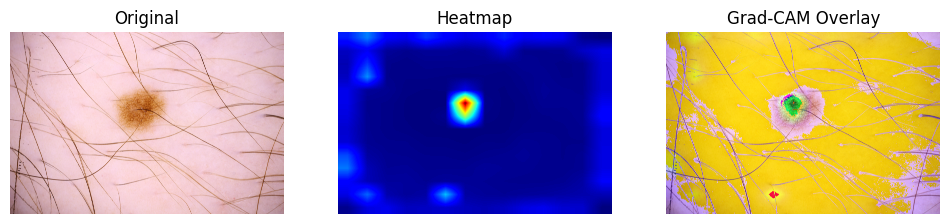

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
category：UNK, probability=0.2520


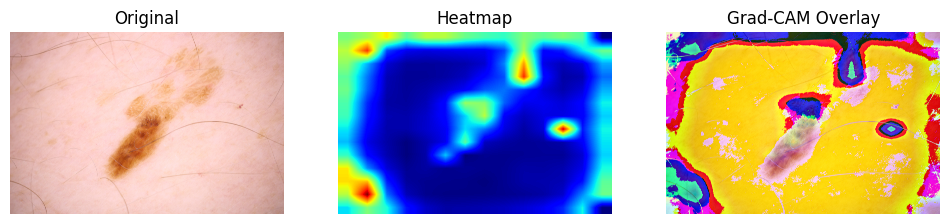

In [20]:
images = []
for filename in os.listdir(image_dir):
    img = cv2.imread(os.path.join(image_dir, filename))
    if img is not None:
        images.append(img)

label = pd.read_csv(TRAIN_CSV)
class_names = sorted(label["diagnosis"].unique())
label2idx = {c: i for i, c in enumerate(class_names)}
idx2label = {i: c for c, i in label2idx.items()}

for i in range(2):
    pred_idx, pred_prob, overlay = predict_and_gradcam(
        images[i],
        model,
        alpha=0.4,
        idx2label=idx2label
    )